# Mathematical modeling project finite difference method

## Warning: Main computation takes ~5 mins

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import time
from mpl_toolkits.mplot3d import Axes3D

In [129]:
# Constants used

# Important units used: micrometers, seconds; concentration uses number of particles instead of moles

Nx = 9 # Number of points in x-direction
Ny = Nx # Number of points in y-direction
Nz = 6 # Number of points in z-direction
Nt = 30001 # Number of points in time

N1 = Nx*Ny*Nz # Total number of points
N2 = Nx*Ny # Number of points in one layer
N3 = (Nx-1)*(Ny-1)*(Nz-1) # Number of small volumes between points

k_on = 4e11*1e15/(6.022e23) # Reaction constant from R + N --> R-N, also called k_1, changed from original value
                              # and units changed to remove mol^-1 and change meters to micrometers
k_off = 5e6 # Reaction constant from R-N --> R + N, also called k_-1, changed from original value
D = 8e5 # Diffusion coefficient

h = 0.015 # Height of the synaptic cleft
r = 0.22 # Radius of the synaptic cleft
V = np.pi*r**2*h # Volume of the synaptic cleft

dx_ = 2*r/(Nx-1) # Size of step in x-direction
dy_ = dx_ # Size of step in y-direction
dz_ = h/(Nz-1) # Size of step in z-direction
L = r # Length scale
T = L**2/D # Time scale
t_end = 5 # Scaled end time

dx = dx_/L # Scaled step in x-direction
dy = dy_/L # Scaled step in y-direction
dz = dz_/L # Scaled step in z-direction
dt = t_end/Nt # Scaled time step

epsilon = dz_ # Height of volume where receptors can react

rho = 1000 # Density of receptors on the membrane
N_e = 5000 #Number of transmitters released in one excitation

R0 = rho/epsilon # Scale of C_RN
C = N_e/V # Scale of C_N

activation = 0.5 # Fraction of bound receptors needed before the signal is sent


# CFL-conditions
print("CFL-condition 1:",dt*(1/dx**2+1/dy**2+1/dz**2+1/2*k_on*R0*T),"< 1")
print("CFL-condition 2:",dt/2*T*(k_on*C*N2 + k_off),"< 1") # Due to scaling, max value of C_N < N2 in the RN-layer

CFL-condition 1: 0.9027158164558223 < 1
CFL-condition 2: 0.5946560373401555 < 1


In [101]:
# Converts indices to x,y,z-coordinates
def to_xyz(i,j,k):
    return (i-(Nx-1)/2)*dx, (j-(Ny-1)/2)*dy, (k-(Nz-1)/2)*dz

# Checks if a certain point is within the domain
def is_in_domain(x,y):
    return  (x**2+y**2)<=1

# Converts from single index to triple index
def to_coords(l):
    return (l%(Nx*Ny))%Ny, (l%(Nx*Ny))//Ny, l//(Nx*Ny)

# Convert from triple index to single index
def to_index(i,j,k):
    return i + Ny*j + Nx*Ny*k

In [102]:
# Initiate vectors and matrices

# To create a history of values (will give 11 points)
N_hist = Nt//100

# Vector that holds concentration of neurotransmitters in N1=Nx*Ny*Nz points
C_N = np.zeros(N1)

# Will save historical values of C_N
C_N_hist = []

# Matrices and vector used to calculate each new C_N
A_N = np.zeros((N1,N1))
B_N = np.zeros((N1,N1))
F_N = np.zeros(N1)

# Vector that holds concentration of neurotransmitters in N2=Nx*Ny points (no need for Nz as it is only in one layer)
C_RN = np.zeros(N2)

# Will save historical values of C_RN
C_RN_hist = []

# Matrices and vector used to calculate each new C_RN
A_RN = np.zeros((N2,N2))
B_RN = np.zeros((N2,N2))
F_RN = np.zeros(N2)

# Finds how many points are within the domain
N_domain = 0
for l in range(N2):
    i,j,k = to_coords(l)
    x,y,z = to_xyz(i,j,k)
    if is_in_domain(x,y):
        N_domain += 1
print(N_domain/N2)

dV = V/(N_domain*Nz) # Size of volume associated with each point

# Set initial condition of C_N. Since it is scaled by N_e/V and the concentration in one point is N_e/dV, the scaled
# initial value is V/dV. The neurotransmitters are released in a single point in the middle of layer 0, but could also be
# released in other points if wanted.
C_N[to_index(Nx//2,Ny//2,0)] = V/dV

# Saves first value of C_N
C_N0 = C_N

#Saves first value of C_RN
C_RN0 = C_RN

0.6049382716049383


In [103]:
# Main computation

# To check how long time the computation takes
t0 = time.time()

# To log the average value of points within boundary of C_RN, giving the fraction of bound receptors due to the
# scaling that is used
csum_RN = np.zeros(Nt)

# To log the average value of points within boundary of C_N, giving the fraction of bound receptors due to the
# scaling that is used
csum_N = np.zeros(Nt)

# Computation of C_N and C_RN for every time step
for t in range(Nt):
    
    # Saves max and average value of C_RN and C_N
    csum_RN[t] = np.sum(C_RN)/N_domain
    csum_N[t] = np.sum(C_N)/(N_domain*Nz)
    
    # Saves values of C_N and C_RN
    if t%N_hist == 1:
        C_N_hist.append(C_N)
        C_RN_hist.append(C_RN)
    
    # Creates A_N, B_N, F_N
    for l in range(N1):
        i,j,k = to_coords(l)
        x,y,z = to_xyz(i,j,k)
        
        # Points not in domain will be set to zero, so their value in A_N is 1, and in B_N and F_N it is 0
        if (not is_in_domain(x,y)):
            A_N[l][l] = 1
            
        # For points within the domain
        else:
            # For points that are not at the boundary in z-direction
            if k != Nz-1 and k != 0:
                A_N[l][l] = 1 + dt*(1/dx**2+1/dy**2+1/dz**2) + dt/2*k_on*R0*T
                A_N[l][to_index(i,j,k+1)] = -dt/(2*dz**2)
                A_N[l][to_index(i,j,k-1)] = -dt/(2*dz**2)

                B_N[l][l] = 1 - dt*(1/dx**2+1/dy**2+1/dz**2) - dt/2*k_on*R0*T
                B_N[l][to_index(i,j,k+1)] = dt/(2*dz**2)
                B_N[l][to_index(i,j,k-1)] = dt/(2*dz**2)
            
            # The terms are adjusted to stop flow out of synaptic cleft in z-direction
            elif k==Nz-1:
                A_N[l][l] = 1 + dt*(1/dx**2+1/dy**2+1/(2*dz**2)) + dt/2*k_on*R0*T*(1-C_RN[to_index(i,j,0)])
                A_N[l][to_index(i,j,k-1)] = -dt/(2*dz**2)
                

                B_N[l][l] = 1 - dt*(1/dx**2+1/dy**2+1/(2*dz**2)) - dt/2*k_on*R0*T*(1-C_RN[to_index(i,j,0)])
                B_N[l][to_index(i,j,k-1)] = dt/(2*dz**2)

                F_N[l] = dt*k_off*R0*T/C*C_RN[to_index(i,j,0)]
            
            # The terms are adjusted to stop flow out of synaptic cleft in z-direction
            elif k==0:
                A_N[l][l] = 1 + dt*(1/dx**2+1/dy**2+1/(2*dz**2)) + dt/2*k_on*R0*T
                A_N[l][to_index(i,j,k+1)] = -dt/(2*dz**2)

                B_N[l][l] = 1 - dt*(1/dx**2+1/dy**2+1/(2*dz**2)) - dt/2*k_on*R0*T
                B_N[l][to_index(i,j,k+1)] = dt/(2*dz**2)

            # Flow out of bounds is not stopped, which can be explained by glial cells immediately reacting with
            # neurotransmitters outside of synaptic cleft
            
            if i != Nx-1:
                A_N[l][to_index(i+1,j,k)] = -dt/(2*dx**2)

                B_N[l][to_index(i+1,j,k)] = dt/(2*dx**2)

            if i != 0:
                A_N[l][to_index(i-1,j,k)] = -dt/(2*dx**2)

                B_N[l][to_index(i-1,j,k)] = dt/(2*dx**2)

            if j != Ny-1:
                A_N[l][to_index(i,j+1,k)] = -dt/(2*dy**2)

                B_N[l][to_index(i,j+1,k)] = dt/(2*dy**2)

            if j != 0:
                A_N[l][to_index(i,j-1,k)] = -dt/(2*dy**2)

                B_N[l][to_index(i,j-1,k)] = dt/(2*dy**2)
    
    # Creates B_RN, F_RN
    for l in range(N2):
        i,j,k = to_coords(l)
        x,y,z = to_xyz(i,j,k)
        
        # Points within the domain
        if is_in_domain(x,y):
            
            B_RN[l][l] = 1 - dt/2*T*(k_on*C*C_N[to_index(i,j,Nz-1)] + k_off)

            F_RN[l] = k_on*C*T*dt*C_N[to_index(i,j,Nz-1)]/2 

    # Solve linear equation to find new C_N
    C_N = np.linalg.solve(A_N,np.dot(B_N,C_N) + F_N)
    
    # Creates A_RN and finishes the F_RN-vector, has to be done after calculating the new C_N to be proper Crank-Nicolson
    for l in range(N2):
        i,j,k = to_coords(l)
        x,y,z = to_xyz(i,j,k)
        if (not is_in_domain(x,y)):
            A_RN[l][l] = 1
        else:
            A_RN[l][l] = 1 + dt/2*T*(k_on*C*C_N[to_index(i,j,Nz-1)] + k_off)

            F_RN[l] += k_on*C*T*dt*C_N[to_index(i,j,Nz-1)]/2
    
    # Solve linear equation to find new C_RN
    C_RN = np.linalg.solve(A_RN,np.dot(B_RN,C_RN) + F_RN)

# How long the computation took in seconds
print("Time: {}s".format(round(time.time()-t0),1))

Time: 261.7638647556305


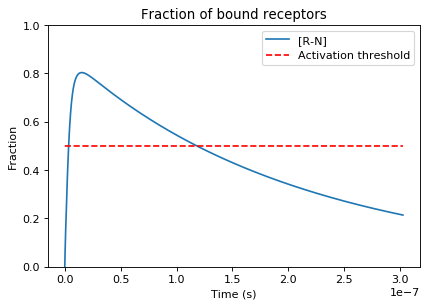

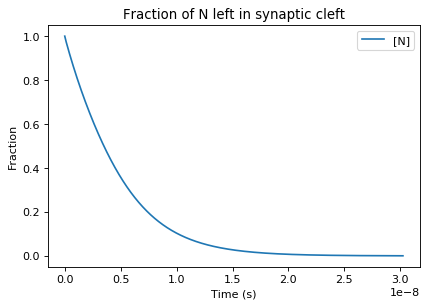

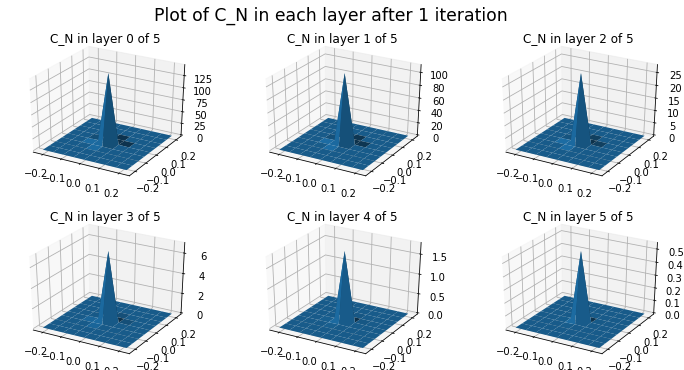

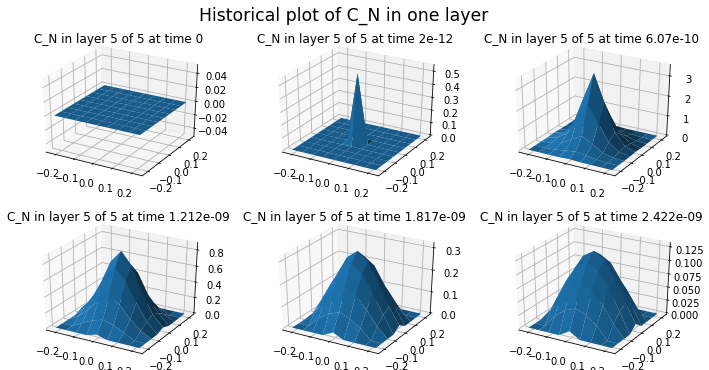

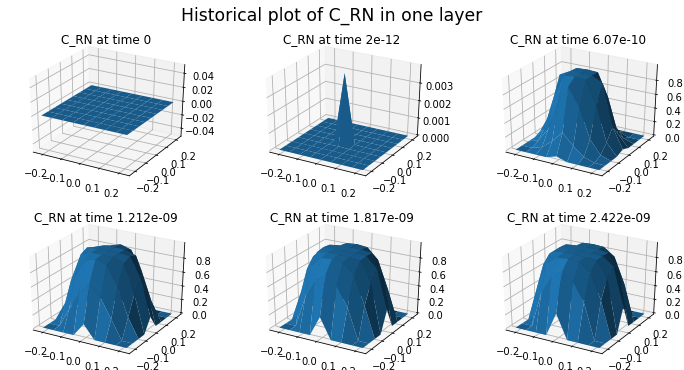

In [125]:
# Plots results

act_lim = np.ones(Nt)*activation # Used to show activation limit
t_vals = np.linspace(0,t_end,Nt)*T # Time values for plotting (in seconds)

# Plots fraction of bound receptors and shows where it crosses the activation threshold
plt.figure(dpi=80)
plt.ylim(0,1)
plt.title("Fraction of bound receptors")
plt.plot(t_vals,csum_RN,label="[R-N]")
plt.plot(t_vals,act_lim,"--",color="red",label="Activation threshold")
plt.xlabel("Time (s)")
plt.ylabel("Fraction")
plt.legend()
plt.show()

# Plots fraction of N left in the system
plt.figure(dpi=80)
plt.title("Fraction of N left in synaptic cleft")
plt.plot(t_vals[:Nt//10],csum_N[:Nt//10],label="[N]")
plt.xlabel("Time (s)")
plt.ylabel("Fraction")
plt.legend()
plt.show()

print("")

# Used to plot C_N and C_RN in 3D with correct x and y scales
x_vec = np.linspace(-r,r,Nx)
y_vec = x_vec.copy()
x,y = np.meshgrid(x_vec,y_vec)

# 3D-plot of C_N in each layer
fig,axs = plt.subplots(2,3,subplot_kw={"projection": "3d"},figsize=(12,6))
fig.suptitle("Plot of C_N in each layer after 1 iteration",x=0.5,y=0.95,size="xx-large")
for u in range(2):
    for v in range(3):
        axs[u,v].set_title("C_N in layer {layer} of {nlayer}".format(layer=3*u+v,nlayer=Nz-1))
        axs[u,v].plot_surface(x,y,np.reshape(C_N_hist[0][to_index(0,0,3*u+v):to_index(Nx-1,Ny-1,3*u+v)+1],(Nx,Ny)))
plt.show()

print("")

# Historical 3D-plot of C_N in one layer
fig2,axs = plt.subplots(2,3,subplot_kw={"projection": "3d"},figsize=(12,6))
fig2.suptitle("Historical plot of C_N in one layer",x=0.5,y=0.95,size="xx-large")
axs[0,0].set_title("C_N in layer {layer} of {nlayer} at time {time}".format(layer=Nz-1,nlayer=Nz-1,time=0))
axs[0,0].plot_surface(x,y,np.reshape(C_N0[to_index(0,0,Nz-1):to_index(Nx-1,Ny-1,3*u+v)+1],(Nx,Ny)))
for u in range(2):
    for v in range(3):
        if u+v!=0:
            axs[u,v].set_title("C_N in layer {layer} of {nlayer} at time {time}".format(layer=Nz-1,nlayer=Nz-1,time=round(((3*u+v-1)*(N_hist)+1)*T/Nt,12)))
            axs[u,v].plot_surface(x,y,np.reshape(C_N_hist[3*u+v-1][to_index(0,0,Nz-1):to_index(Nx-1,Ny-1,Nz-1)+1],(Nx,Ny)))
plt.show()

print("")

# Historical 3D-plot of C_RN in one layer
fig3,axs = plt.subplots(2,3,subplot_kw={"projection": "3d"},figsize=(12,6))
fig3.suptitle("Historical plot of C_RN in one layer",x=0.5,y=0.95,size="xx-large")
#fig3.subplots_adjust(bottom=0)
axs[0,0].set_title("C_RN at time {time}".format(time=0))
axs[0,0].plot_surface(x,y,np.reshape(C_RN0,(Nx,Ny)))
for u in range(2):
    for v in range(3):
        if u+v!=0:
            axs[u,v].set_title("C_RN at time {time}".format(time=round(((3*u+v-1)*(N_hist)+1)*T/Nt,12)))
            axs[u,v].plot_surface(x,y,np.reshape(C_RN_hist[3*u+v-1],(Nx,Ny)))
plt.show()